In [278]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats.mstats import rankdata
from aslib_scenario.aslib_scenario import ASlibScenario
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import matplotlib.gridspec as gridspec


### Matplotlib settings ###
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
sns.set_style('darkgrid')
sns.set_context(font_scale=5.0, rc={"lines.linewidth": 3.0})

%matplotlib inline

# Heatmap

In [ ]:
data = pd.read_csv(r'./results.csv', header=None)
data.columns = ['scenario', 'approach', 'metric', 'normalized', 'num_results']
    
num_approaches = data['Algorithm Selector'].nunique()
data = data.pivot('ASlib Scenarios','Algorithm Selector','normalized')
data = data.fillna(100.0)

fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gs = gridspec.GridSpec(4, 1, width_ratios=[20], height_ratios=[100, 5, 5, 5], figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

normal_vmax = 1.5

palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)


heatmap = sns.heatmap(data, cmap=palette, linewidths=.5, ax=ax1, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax)
ax1.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
labels = ax1.get_xticklabels()
ax1.set_xticklabels(labels, rotation=45, ha='left')
ax1.set_xlabel('')
ax1.set_ylabel('')

num_scenarios, num_algorithms = data.values.shape
for scenario_id in range(num_scenarios):
    tmp = ax1.texts[scenario_id * num_algorithms: scenario_id * num_algorithms + num_algorithms]    
    min_val = min([float(text.get_text()) for text in tmp])
    indices = [num for num, text in enumerate(tmp) if float(text.get_text()) == min_val]
    
    for idx in indices:
        text = tmp[idx]
        text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')



bottom_palette =sns.color_palette("Purples", n_colors=100)
ax2_data = np.median(data.values, axis=0)
ax2_data = ax2_data.reshape(1, ax2_data.size)
ax2_vmin, ax2_vmax = np.nanmin(ax2_data), np.nanmax(ax2_data)
ax2_offset = 0.05
sns.heatmap(ax2_data, ax=ax2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin-ax2_offset, vmax=ax2_vmax+ax2_offset)
ax1.set_ylabel('')
ax2.set_ylabel('Median', rotation=0, labelpad=30)
#ax2.yaxis.set_label_coords(-0.1,1.02)    
min_val = min([float(text.get_text()) for text in ax2.texts])
indices = [num for num, text in enumerate(ax2.texts) if float(text.get_text()) == min_val]

for idx in indices:
    text = ax2.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')


ax3_data = np.mean(data.values, axis=0)
ax3_data = ax3_data.reshape(1, ax3_data.size)
ax3_vmin, ax3_vmax = np.nanmin(ax3_data), np.nanmax(ax3_data)
ax3_offset = 0.2
sns.heatmap(ax3_data, ax=ax3, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin-ax3_offset, vmax=ax3_vmax+ax3_offset)
ax3.set_ylabel('Mean', rotation=0, labelpad=30)
#ax2.yaxis.set_label_coords(-0.1,1.02)
min_val = min([float(text.get_text()) for text in ax3.texts])
indices = [num for num, text in enumerate(ax3.texts) if float(text.get_text()) == min_val]

for idx in indices:
    text = ax3.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')

ax4_data = rankdata(data.values, axis=1)
ax4_data = np.mean(ax4_data, axis=0)
ax4_data = ax4_data.reshape(1, ax4_data.size)
ax4_vmin, ax4_vmax = 1, np.size(ax4_data, axis=1)
sns.heatmap(ax4_data, ax=ax4, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
ax4.set_ylabel('Mean Rank', rotation=0, labelpad=35)
#ax2.yaxis.set_label_coords(-0.1,1.02)
min_val = min([float(text.get_text()) for text in ax4.texts])
indices = [num for num, text in enumerate(ax4.texts) if float(text.get_text()) == min_val]

for idx in indices:
    text = ax4.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')
    

fig.savefig(r'./heatmap.pdf')
fig.show()

# Fit Survival Forest on QBF-2011

In [279]:
##### Load ASlib Scenario #####
scenario_name = 'QBF-2011'
fold = 1
scenario = ASlibScenario()
scenario.read_scenario('/workspaces/aslib/' + scenario_name)
test_scenario, train_scenario = scenario.get_split(indx=fold)
num_algorithms = len(train_scenario.algorithms)
num_instances = train_scenario.instances
algorithm_cutoff_time = train_scenario.algorithm_cutoff_time
features = train_scenario.feature_data.to_numpy()
performances = train_scenario.performance_data.to_numpy()


##### Fit Random Survival Forest #####
def construct_dataset_for_algorithm_id(instance_features, performances, algorithm_id: int,
                                           algorithm_cutoff_time):
    # get runtimes of algorithm 
    performances_of_algorithm_with_id = performances.iloc[:, algorithm_id].to_numpy() if isinstance(performances, pd.DataFrame) else performances[:, algorithm_id]
    num_instances = len(performances_of_algorithm_with_id)

    # for each instance determine whether it was finished before cutoff; also set PAR10 values
    finished_before_timeout = np.empty(num_instances, dtype=bool)
    for i in range(0, len(performances_of_algorithm_with_id)):
        finished_before_timeout[i] = True if (performances_of_algorithm_with_id[i] < algorithm_cutoff_time) else False
        if performances_of_algorithm_with_id[i] >= algorithm_cutoff_time:
            performances_of_algorithm_with_id[i] = (algorithm_cutoff_time * 10)

    # for each instance build target, consisting of (censored, runtime)
    status_and_performance_of_algorithm_with_id = np.empty(dtype=[('cens', np.bool), ('time', np.float)],
                                                           shape=instance_features.shape[0])
    status_and_performance_of_algorithm_with_id['cens'] = finished_before_timeout
    status_and_performance_of_algorithm_with_id['time'] = performances_of_algorithm_with_id

    if isinstance(instance_features, pd.DataFrame):
        instance_features = instance_features.to_numpy()

    return instance_features, status_and_performance_of_algorithm_with_id.T


imputer = [SimpleImputer() for _ in range(num_algorithms)]
scaler = [StandardScaler() for _ in range(num_algorithms)]
params = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 15, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': False}
models = [RandomSurvivalForest(n_estimators=params['n_estimators'],
                         min_samples_split=params['min_samples_split'],
                         min_samples_leaf=params['min_samples_leaf'],
                         min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
                         max_features=params['max_features'],
                         bootstrap = params['bootstrap'],
                         oob_score= params['oob_score'],
                         n_jobs=1,
                         random_state=fold) for _ in range(num_algorithms)]

for alg_id in range(num_algorithms):
    # prepare survival forest dataset and split the data accordingly
    X_train, Y_train = construct_dataset_for_algorithm_id(features, performances, alg_id, algorithm_cutoff_time)            
    X_train = imputer[alg_id].fit_transform(features)
    X_train = scaler[alg_id].fit_transform(X_train)
    models[alg_id].fit(X_train, Y_train)

    
##### Predict Survival Functions and respective Risks #####
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


Optional file not found: /workspaces/aslib/QBF-2011/ground_truth.arff
Optional file not found: /workspaces/aslib/QBF-2011/feature_costs.arff
Have not found features_cutoff_time
Have not found features_cutoff_memory
Have not found features_stochastic
Found 114 duplicated feature vectors
Index(['C880.blif_0.10_0.20_0_0_out_exact',
       'C880.blif_0.10_0.20_0_1_out_exact',
       'Core1108_tbm_02.tex.moduleQ3.2S.000007',
       'Core1108_tbm_02.tex.moduleQ3.2S.000077',
       'Core1108_tbm_02.tex.moduleQ3.2S.000099',
       'Core1108_tbm_02.tex.moduleQ3.2S.000108',
       'Core1108_tbm_03.tex.module.000038',
       'Core1108_tbm_03.tex.module.000039',
       'Core1108_tbm_03.tex.moduleQ3.2S.000002',
       'Core1108_tbm_03.tex.moduleQ3.2S.000009',
       ...
       'robots_1_5_5_8.4', 'robots_1_5_5_87.4', 'robots_1_5_5_93.4',
       'robots_1_5_5_95.8', 'robots_1_5_5_97.2', 'robots_1_5_5_99.8',
       'test1_quant2', 'test1_quant_squaring2', 'test4_quant2',
       'test4_quant_squaring2

# Predictions, Survival Functions & Event Times

In [286]:
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


# Survival Functions Plot

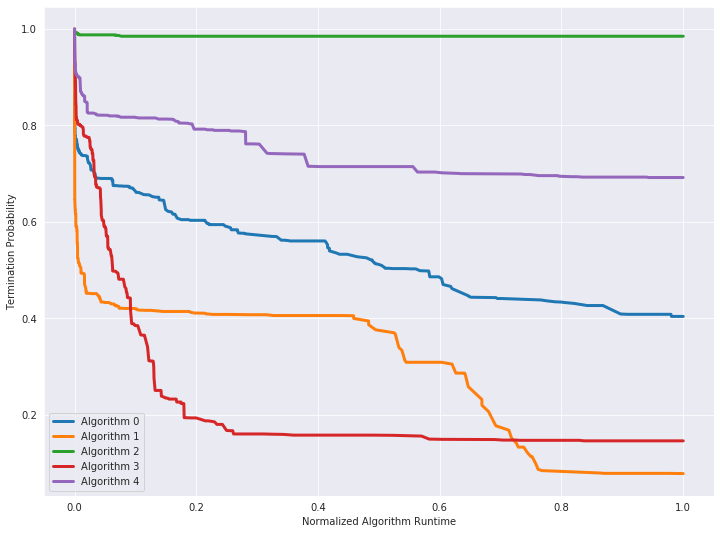

In [287]:
# set figure settings
fig, ax = plt.subplots(figsize=(12, 9))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Termination Probability')
ax.set_xlabel('Normalized Algorithm Runtime')

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=ax, label='Algorithm {}'.format(alg_id))
    
fig.savefig(r'./survival_functions.pdf')
fig.show()

# Cumulated Risk Score Plots

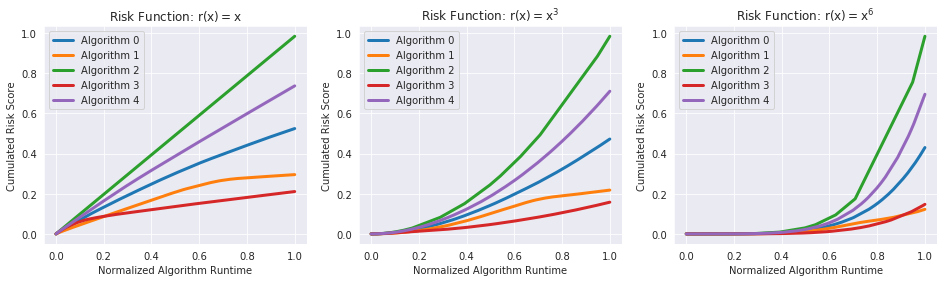

In [292]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**2, lambda x: x**5]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Cumulated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in range(num_algorithms):
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))

fig.savefig(r'./risk_functions.pdf')
fig.show()

# Cumulated Risk Score Plots (Algorithm 1 & 3)

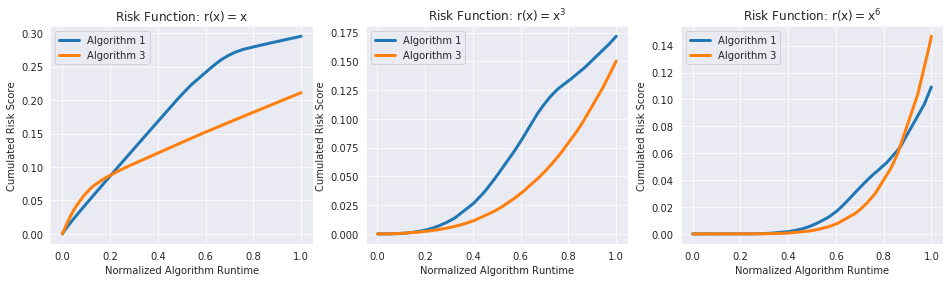

In [293]:
subset = [1, 3]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**3, lambda x: x**6]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Cumulated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in subset:
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))
        
fig.savefig(r'./subset_risk_functions.pdf')
fig.show()

# Cumulated Risk Score Difference (Algorithm 1 & 3)

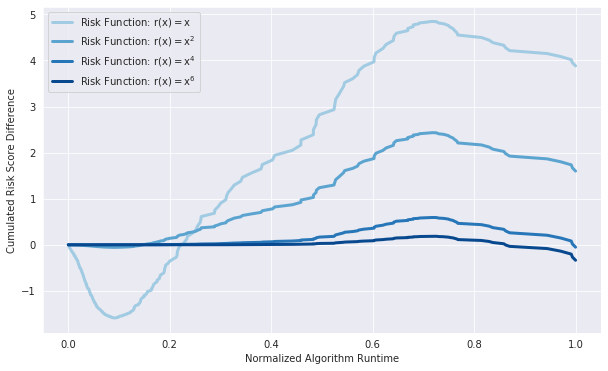

In [302]:
subset = [1, 3]
alg_0 = subset[0]
alg_1 = subset[1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Cumulated Risk Score Difference')
ax.set_xlabel('Normalized Algorithm Runtime')

# compute all events occuring for algorithm 1 and algorithm 3
overall_events = set(event for alg_id in subset for event in event_times[alg_id].tolist())
overall_events.update([0.0, algorithm_cutoff_time])
overall_events = sorted(overall_events)

# compute all respective differences regarding the algorithms' survival probabilities
difference = np.zeros(len(overall_events))
for event_idx, event in enumerate(overall_events):
    # get index of respective survival probability for each algorithm
    idx = np.zeros(len(subset), dtype=int)
    for num, alg_id in enumerate(subset):
        idx[num] = np.argmax(event_times[alg_id] >= event)

    difference[event_idx] = survival_functions[alg_0][idx[0]] - survival_functions[alg_1][idx[1]]
    
overall_events = np.asarray(overall_events) / algorithm_cutoff_time

y1 = np.cumsum(difference * overall_events)
y2 = np.cumsum(difference * overall_events**2)
y3 = np.cumsum(difference * overall_events**4)
y4 = np.cumsum(difference * overall_events**6)

palette = sns.color_palette("Blues", 10)

sns.lineplot(x=overall_events, y=y1, ax=ax, label='Risk Function: $\mathrm{r(x) = x}$', color=palette[3])
sns.lineplot(x=overall_events, y=y2, ax=ax, label='Risk Function: $\mathrm{r(x) = x^2}$', color=palette[5])
sns.lineplot(x=overall_events, y=y3, ax=ax, label='Risk Function: $\mathrm{r(x) = x^4}$', color=palette[7])
sns.lineplot(x=overall_events, y=y4, ax=ax, label='Risk Function: $\mathrm{r(x) = x^6}$', color=palette[9])

fig.savefig(r'./risk_score_differences.pdf')
fig.show()

# Joint Plot

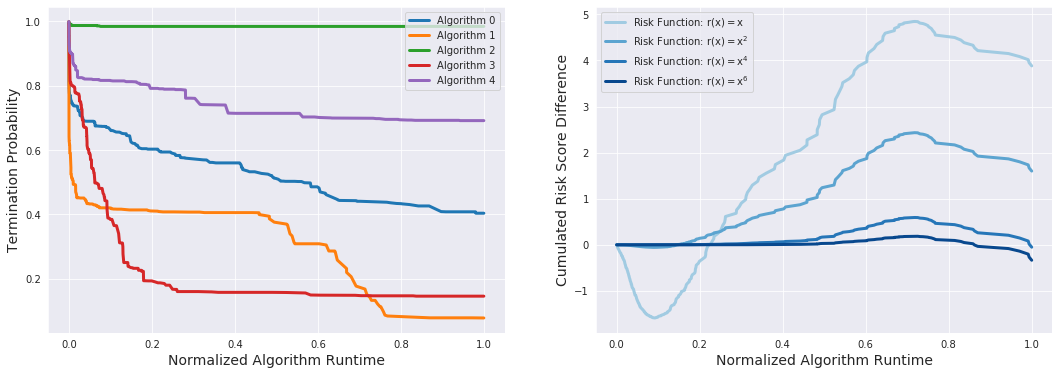

In [301]:
# set figure settings
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


### Survival Plot ###
axes[0].ticklabel_format(useOffset=False, style='plain')
axes[0].set_ylabel('Termination Probability', fontsize=14)
axes[0].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=axes[0], label='Algorithm {}'.format(alg_id))
    
    
### Cumulated Risk Score Difference Plot ###
subset = [1, 3]
alg_0 = subset[0]
alg_1 = subset[1]

axes[1].ticklabel_format(useOffset=False, style='plain')
axes[1].set_ylabel('Cumulated Risk Score Difference',  fontsize=14)
axes[1].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

# compute all events occuring for algorithm 1 and algorithm 3
overall_events = set(event for alg_id in subset for event in event_times[alg_id].tolist())
overall_events.update([0.0, algorithm_cutoff_time])
overall_events = sorted(overall_events)

# compute all respective differences regarding the algorithms' survival probabilities
difference = np.zeros(len(overall_events))
for event_idx, event in enumerate(overall_events):
    # get index of respective survival probability for each algorithm
    idx = np.zeros(len(subset), dtype=int)
    for num, alg_id in enumerate(subset):
        idx[num] = np.argmax(event_times[alg_id] >= event)

    difference[event_idx] = survival_functions[alg_0][idx[0]] - survival_functions[alg_1][idx[1]]
    
overall_events = np.asarray(overall_events) / algorithm_cutoff_time

y1 = np.cumsum(difference * overall_events)
y2 = np.cumsum(difference * overall_events**2)
y3 = np.cumsum(difference * overall_events**4)
y4 = np.cumsum(difference * overall_events**6)

palette = sns.color_palette("Blues", 10)

sns.lineplot(x=overall_events, y=y1, ax=axes[1], label='Risk Function: $\mathrm{r(x) = x}$', color=palette[3])
sns.lineplot(x=overall_events, y=y2, ax=axes[1], label='Risk Function: $\mathrm{r(x) = x^2}$', color=palette[5])
sns.lineplot(x=overall_events, y=y3, ax=axes[1], label='Risk Function: $\mathrm{r(x) = x^4}$', color=palette[7])
sns.lineplot(x=overall_events, y=y4, ax=axes[1], label='Risk Function: $\mathrm{r(x) = x^6}$', color=palette[9])

fig.savefig(r'./joint_plot.pdf')
fig.show()